In [4]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
import nltk
from nltk.corpus import stopwords

nltk.download("punkt_tab")
nltk.download("stopwords")
stopwords_en = set(stopwords.words("english"))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hades\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hades\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Cargar dataset
ruta_ds = "Movies_and_TV_5.json"

reviews = []
with open(ruta_ds, "r") as f:
    for line in f:
        reviews.append(json.loads(line))
df = pd.DataFrame(reviews)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [ ]:
# Se elimina valoraciones de 3 estrellas y se crea columna sentiment
df_limpio = df[df["overall"] != 3].copy()
df_limpio["sentiment"] = df_limpio["overall"].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
# Convtir a minusculas
def minusculas(texto):
    return texto.lower()

In [ ]:
# Limpieza del corpus
def limpiezaCorpus(texto):
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)
    texto = re.sub(r"\d+", "", texto)   
    texto = re.sub(r'\@w+|\#','', texto)
    texto = re.sub(r'[^A-Za-z0-9]+', ' ', texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

In [ ]:
# Tokenizar el texto
def tokensTxt(texto):
    return nltk.word_tokenize(texto)

In [ ]:
# Quitar stopwords
def quitar_Stopwords(tokens):
    return [t for t in tokens if t not in stopwords_en]

In [ ]:
# Agrupar tokens en un solo texto
def agrupar (texto):
    return " ".join(texto)

In [ ]:
#Procesar texto completo de las reseañas
def Procesa_txt(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.strip()
    if not texto:
        return ""
    texto = minusculas(texto)
    
    texto = limpiezaCorpus(texto)
    
    tokens = tokensTxt(texto)
    
    tokens = quitar_Stopwords(tokens)
    
    texto_limpio  = agrupar(tokens)
    
    return "".join(texto_limpio)

In [ ]:
# Aplicar procesamiento de texto
df_limpio["clean_text"] = df["reviewText"].apply(Procesa_txt)
df_limpio.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment,clean_text
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008",1,charming version classic dicken tale henry win...
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",1,henry winkler good twist classic story convent...
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013",1,one best scrooge movies henry winkler outdoes ...
5,A2L0G56BNOTX6S,0005019281,barbara whapeles,"[0, 0]",This has been a favorite movie of mine for a l...,5.0,Dickens updated.,1383696000,"11 6, 2013",1,favorite movie mine long time henry winkler gr...
6,A5NYUBEKXFLX5,0005019281,"B. Babb ""kites0852""","[1, 1]",This is the American adaptation of the Charles...,5.0,A MUST-HAVE FOR ANY VIDEO CHRISTMAS COLLECTION!!,1230595200,"12 30, 2008",1,american adaptation charles dickens classic in...


In [ ]:
# Crear x,y conjunto de entrenamiento y prueba y dividir datos en train y test
X = df_limpio["clean_text"]
y = df_limpio["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Aplicar TfidfVectorizer para convertir el texto en una matriz
tfidf_vec = TfidfVectorizer(max_features=20000,ngram_range=(1,2),min_df=5)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [ ]:
# Entrenar modelo SVM
svm_final = LinearSVC()
svm_final.fit(X_train_tfidf, y_train)

y_pred = svm_final.predict(X_test_tfidf)

In [ ]:
# Imprimir métricas de evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78     41326
           1       0.96      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.90      0.85      0.87    299247
weighted avg       0.94      0.94      0.94    299247



In [ ]:
# Obtener accuracy, precision, recall
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Efectividad: {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

Efectividad: 0.9436
precision: 0.9556
Recall: 0.9801
F1-score: 0.9677


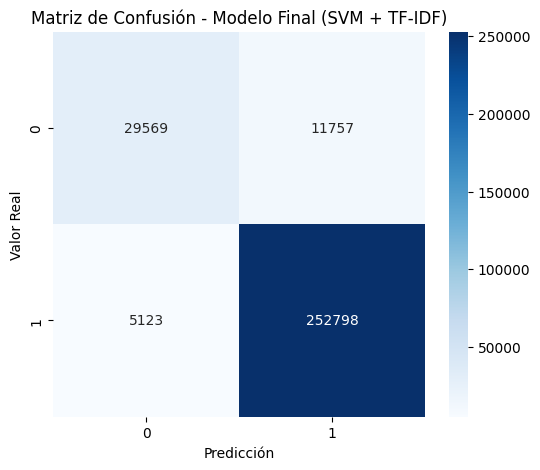

In [ ]:
# Matriz de confusión y visualización de grafico
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión - Modelo Final (SVM + TF-IDF)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()